In [1]:
# Import all of the python packages used in this workflow.
import scipy
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import os, sys
from pylab import *
import pandas as pd
import numpy as np
import osgeo
from osgeo import gdal
from shapely import geometry as sgeom
import osr
import xarray
import ulmo
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import FormatStrFormatter
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import geopandas as gpd
from datetime import datetime
from datetime import timedelta  

###################################### USER INPUTS #######################################

#model filename
parFile = '/nfs/attic/dfh/Aragon2/sm_4/snowmodel.par'
incFile = '/nfs/attic/dfh/Aragon2/sm_4/code/snowmodel.inc'
codeFile = '/nfs/attic/dfh/Aragon2/sm_4/code/snowpack_code.f'
PcorFile = '/nfs/attic/dfh/Aragon2/sm_4/precip_cf/cf_precip.dat'
ctlFile = '/nfs/attic/dfh/Aragon2/sm_4/ctl_files/wo_assim/swed.ctl'
sweFile = '/nfs/attic/dfh/Aragon2/sm_4/outputs/wo_assim/swed.gdat'
roffFile = '/nfs/attic/dfh/Aragon2/sm_4/outputs/wo_assim/roff.gdat'
spreFile = '/nfs/attic/dfh/Aragon2/sm_4/outputs/wo_assim/spre.gdat'
smltFile = '/nfs/attic/dfh/Aragon2/sm_4/outputs/wo_assim/smlt.gdat'
precFile = '/nfs/attic/dfh/Aragon2/sm_4/outputs/wo_assim/prec.gdat'
rpreFile = '/nfs/attic/dfh/Aragon2/sm_4/outputs/wo_assim/rpre.gdat'
tairFile = '/nfs/attic/dfh/Aragon2/sm_4/outputs/wo_assim/tair.gdat'
ssubFile = '/nfs/attic/dfh/Aragon2/sm_4/outputs/wo_assim/ssub.gdat'

# Snotel projection
stn_proj = 'epsg:4326' #WGS84
#model projection
mod_proj = 'epsg:32612' #UTM zone 12N

# Import CSO gdf (metadata) and df (daily data) 

In [18]:
gdf = gpd.read_file('../CSO_SNOTEL_sites.geojson')
df = pd.read_csv('../CSO_SNOTEL_data_SWEDmeters.csv') 
gdf.head()

,code,longitude,latitude,name,elevation_m,easting,northing,geometry
0,314_WY_SNTL,-110.445442,43.940189,Base Camp,2151.887939453125,544505.845453,4.865379e+06,POINT (-110.44544 43.94019)
1,347_MT_SNTL,-111.128029,44.508320,Black Bear,2490.216064453125,489823.440274,4.928341e+06,POINT (-111.12803 44.50832)
2,350_WY_SNTL,-109.793327,44.376671,Blackwater,2980.944091796875,596129.923439,4.914418e+06,POINT (-109.79333 44.37667)
3,353_WY_SNTL,-110.609734,42.964001,Blind Bull Sum,2636.52001953125,531828.554679,4.756891e+06,POINT (-110.60973 42.96400)
4,379_WY_SNTL,-109.670212,43.697330,Burroughs Creek,2667,607155.527746,4.839116e+06,POINT (-109.67021 43.69733)


# Function to edit text files 
## Edit snowmodel.par and snowmodel.inc to run SnowModel as line -> original code

In [16]:
#likely a way to do this with a dictionary 
def replace_line(file_name, line_num, text):
    lines = open(file_name, 'r').readlines()
    lines[line_num] = text
    out = open(file_name, 'w')
    out.writelines(lines)
    out.close()

In [ ]:
#edit snowmodel.par
replace_line(parFile, 32, '      nx = '+str(np.shape(gdf)[0])+'\n')
replace_line(parFile, 33, '      ny = 1\n')
replace_line(parFile, 49, '      xmn = 487200.\n')
replace_line(parFile, 50, '      ymn = 4690100.\n')
replace_line(parFile, 122, '      met_input_fname = met/mm_wy_2014-2019.dat\n')
replace_line(parFile, 149, '      topo_ascii_fname = topo_vege/DEM_WY.asc\n')
replace_line(parFile, 150, '      veg_ascii_fname = topo_vege/NLCD2016_WY.asc\n')
replace_line(parFile, 249, '      xlat = 40.2\n')
replace_line(parFile, 302, '      run_snowtran = 0.0\n')
replace_line(parFile, 465, '      barnes_lg_domain = 1.0\n')
replace_line(parFile, 509, '      snowmodel_line_flag = 1.0\n')

#edit snowmodel.inc
replace_line(incFile, 13, '      parameter (nx_max='+str(np.shape(gdf)[0]+1)+',ny_max=2)\n')

# Functions to adjust calibraiton parameters
## Edit snowmodel.par to run SnowModel as line -> Dave's code

In [23]:
parFile = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_code_edits/snowmodel.par'
incFile = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_code_edits/code/snowmodel.inc'
compileFile = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_code_edits/code/compile_snowmodel.script'
ctlFile = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_code_edits/ctl_files/wo_assim/swed.ctl'
sweFile = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_code_edits/outputs/wo_assim/swed.gdat'
roffFile = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_code_edits/outputs/wo_assim/roff.gdat'
spreFile = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_code_edits/outputs/wo_assim/spre.gdat'
smltFile = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_code_edits/outputs/wo_assim/smlt.gdat'
precFile = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_code_edits/outputs/wo_assim/prec.gdat'
rpreFile = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_code_edits/outputs/wo_assim/rpre.gdat'
tairFile = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_code_edits/outputs/wo_assim/tair.gdat'
ssubFile = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_code_edits/outputs/wo_assim/ssub.gdat'

In [50]:
#Create dictionay with parameter names as keys
par_paramsFile = '/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_code_edits/snowmodel_copy_2.par'
def getparams(file_name):
    myvars = {}
    lines = open(file_name, 'r').readlines()
    for i in range(len(lines)):
        line=lines[i]
        var, name = line.partition("!")[::2]
        #create a dictionary with the variable name as the key for the 
        #[model value, parFile text, linenumber]
        myvars[name.split()[0]] = [var.strip(),name,i+1]
    return myvars

#Edit the par file to set parameters with new values
def edit_par(par_dict,parameter,new_value):
    lines = open(parFile, 'r').readlines()
    text = str(new_value)+'\t\t\t!'+par_dict[parameter][1]
    lines[par_dict[parameter][2]-1] = text
    out = open(parFile, 'w')
    out.writelines(lines)
    out.close()
    
base = getparams(par_paramsFile)
print(base.keys())

dict_keys(['nx', 'ny', 'deltax', 'deltay', 'xmn', 'ymn', 'dt', 'iyear_init', 'imonth_init', 'iday_init', 'xhour_init', 'max_iter', 'isingle_stn_flag', 'igrads_metfile', 'met_input_fname', 'undef', 'ascii_topoveg', 'topoveg_grads_fname', 'topo_ascii_fname', 'veg_ascii_fname', 'ved_shd_25', 'ved_shd_26', 'ved_shd_27', 'ved_shd_28', 'ved_shd_29', 'ved_shd_30', 'const_veg_flag', 'iveg_ht_flag', 'xlat', 'lat_solar_flag', 'UTC_flag', 'run_micromet', 'run_enbal', 'run_snowpack', 'run_snowtran', 'irun_data_assim', 'ihrestart_flag', 'i_dataassim_loop', 'ihrestart_inc', 'i_tair_flag', 'i_rh_flag', 'i_wind_flag', 'i_solar_flag', 'i_longwave_flag', 'i_prec_flag', 'ifill', 'iobsint', 'dn', 'barnes_lg_domain', 'n_stns_used', 'snowmodel_line_flag', 'check_met_data', 'curve_len_scale', 'slopewt', 'curvewt', 'curve_lg_scale_flag', 'windspd_min', 'lapse_rate_user_flag', 'iprecip_lapse_rate_user_flag', 'iprecip_scheme', 'snowfall_frac', 'wind_lapse_rate', 'calc_subcanopy_met', 'gap_frac', 'cloud_frac_fac

In [57]:
print(base['xhour_init'])

['3.0', 'xhour_init - start hour\n', 11]


In [60]:
#edit snowmodel.par
edit_par(base,'nx',np.shape(gdf)[0])
edit_par(base,'ny',1)
edit_par(base,'xmn',487200)
edit_par(base,'ymn',4690100)
edit_par(base,'dt',21600)
edit_par(base,'iyear_init',2014)
edit_par(base,'imonth_init',10)
edit_par(base,'iday_init',1)
edit_par(base,'xhour_init',0)
edit_par(base,'max_iter',7300)
edit_par(base,'met_input_fname','met/mm_wy_2014-2019.dat')
edit_par(base,'ascii_topoveg',1)
edit_par(base,'topo_ascii_fname','topo_vege/DEM_WY.asc')
edit_par(base,'veg_ascii_fname','topo_vege/NLCD2016_WY.asc')
edit_par(base,'xlat',40.2)
edit_par(base,'run_snowtran',0)
edit_par(base,'barnes_lg_domain',1)
edit_par(base,'snowmodel_line_flag',1)
edit_par(base,'print_inc',4)
edit_par(base,'print_var_01','y')
edit_par(base,'print_var_09','y')
edit_par(base,'print_var_10','y')
edit_par(base,'print_var_11','y')
edit_par(base,'print_var_12','y')
edit_par(base,'print_var_14','y')
edit_par(base,'print_var_18','y')

#edit snowmodel.inc
replace_line(incFile, 12, '      parameter (nx_max='+str(np.shape(gdf)[0]+1)+',ny_max=2)\n')

#edit compile_snowmodel.script
replace_line(compileFile, 16, '#pgf77 -O3 -mcmodel=medium -I$path -o ../snowmodel $path$filename1 $path$filename2 $path$filename3 $path$filename4 $path$filename5 $path$filename6 $path$filename7 $path$filename8 $path$filename9 $path$filename10\n')
replace_line(compileFile, 20, 'gfortran -O3 -mcmodel=medium -I$path -o ../snowmodel $path$filename1 $path$filename2 $path$filename3 $path$filename4 $path$filename5 $path$filename6 $path$filename7 $path$filename8 $path$filename9 $path$filename10\n')

In [62]:
#Compile SnowModel - with Dave's code - should only have to do this once
%cd /nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_code_edits/code/
#run compile script 
! ./compile_snowmodel.script
%cd  /nfs/attic/dfh/Aragon2/Notebooks

/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_code_edits/code
/nfs/attic/dfh/Aragon2/Notebooks


In [63]:
def runSnowModel():
    %cd /nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_code_edits/
    ! nohup ./snowmodel
    %cd  /nfs/attic/dfh/Aragon2/Notebooks
    #get model data from .ctl file 
    f=open(ctlFile)
    lines=f.readlines()
    nx = int(lines[9].split()[1])
    xll = int(float(lines[9].split()[3]))
    clsz = int(float(lines[9].split()[4]))
    ny = int(lines[10].split()[1])
    yll = int(float(lines[10].split()[3]))
    num_sim_days = int(lines[14].split()[1])
    st = datetime.strptime(lines[14].split()[3][3:], '%d%b%Y').date()
    ed = st + timedelta(days=(num_sim_days-1))
    print('nx=',nx,'ny=',ny,'xll=',xll,'yll=',yll,'clsz=',clsz,'num_sim_days=',num_sim_days,'start',st,'end',ed)
    f.close()
    return nx, ny, xll, yll, clsz, num_sim_days, st, ed

nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel()

/nfs/attic/dfh/Aragon2/mar2020_snowmodel-dfhill_code_edits
nohup: ignoring input and appending output to ‘nohup.out’
/nfs/attic/dfh/Aragon2/Notebooks
nx= 30 ny= 1 xll= 487200 yll= 4690100 clsz= 100 num_sim_days= 1825 start 2014-10-01 end 2019-09-29


# Function to compile/run SnowModel and extract relevant forcing parameters

In [2]:
#run compile script 
def runSnowModel():
    %cd /nfs/attic/dfh/Aragon2/sm_4/code/
    #run compile script 
    ! ./compile_snowmodel.script
    #run SnowModel
    %cd /nfs/attic/dfh/Aragon2/sm_4/
    ! nohup ./snowmodel
    %cd  /nfs/attic/dfh/Aragon2/Notebooks
    #get model data from .ctl file 
    f=open(ctlFile)
    lines=f.readlines()
    nx = int(lines[9].split()[1])
    xll = int(float(lines[9].split()[3]))
    clsz = int(float(lines[9].split()[4]))
    ny = int(lines[10].split()[1])
    yll = int(float(lines[10].split()[3]))
    num_sim_days = int(lines[14].split()[1])
    st = datetime.strptime(lines[14].split()[3][3:], '%d%b%Y').date()
    ed = st + timedelta(days=(num_sim_days-1))
    print('nx=',nx,'ny=',ny,'xll=',xll,'yll=',yll,'clsz=',clsz,'num_sim_days=',num_sim_days,'start',st,'end',ed)
    f.close()
    return nx, ny, xll, yll, clsz, num_sim_days, st, ed

nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel()

/nfs/attic/dfh/Aragon2/sm_4/code
/nfs/attic/dfh/Aragon2/sm_4
nohup: ignoring input and appending output to ‘nohup.out’
/nfs/attic/dfh/Aragon2/Notebooks
nx= 30 ny= 1 xll= 487200 yll= 4690100 clsz= 100 num_sim_days= 1825 start 2014-10-01 end 2019-09-29


# Function to convert SnowModel output to numpy array

This function is to be used when running SnowModel as a line

In [67]:
## Build a function to convert the binary model output to numpy array

def get_mod_output_line(inFile,stn):
    #open the grads model output file, 'rb' indicates reading from binary file
    grads_data = open(inFile,'rb')
    # convert to a numpy array 
    numpy_data = np.fromfile(grads_data,dtype='float32',count=-1)
    #close grads file 
    grads_data.close()
    #reshape the data 
    numpy_data = np.reshape(numpy_data,(num_sim_days,ny,nx))
    #swe only at station point
    data = np.squeeze(numpy_data[:,0,stn]) 

    return data

# Function for calculating performance statistics

In [65]:
#compute model performance metrics
def calc_metrics():
    swe_stats = np.zeros((5,np.shape(gdf)[0]))
    for i in range(np.shape(gdf)[0]):
        mod_swe = get_mod_output_line(sweFile,i)
        loc = gdf['code'][i]
        stn_swe = df[loc].values
        
        #remove days with zero SWE at BOTH the station and the SM pixel
        idx = np.where((stn_swe != 0) | (mod_swe != 0))
        mod_swe = mod_swe[idx]
        stn_swe = stn_swe[idx]
        
        #remove days where station has nan values 
        idx = np.where(~np.isnan(stn_swe))
        mod_swe = mod_swe[idx]
        stn_swe = stn_swe[idx]
        
        #mean absolute error
        swe_stats[0,i] = (sum(abs(mod_swe - stn_swe)))/mod_swe.shape[0]

        #mean bias error
        swe_stats[1,i] = (sum(mod_swe - stn_swe))/mod_swe.shape[0]

        #root mean squared error
        swe_stats[2,i] = np.sqrt((sum((mod_swe - stn_swe)**2))/mod_swe.shape[0])

        # Nash-Sutcliffe model efficiency coefficient, 1 = perfect, assumes normal data 
        nse_top = sum((mod_swe - stn_swe)**2)
        nse_bot = sum((stn_swe - mean(stn_swe))**2)
        swe_stats[3,i] = (1-(nse_top/nse_bot))

        # Kling-Gupta Efficiency, 1 = perfect
        kge_std = (np.std(mod_swe)/np.std(stn_swe))
        kge_mean = (mean(mod_swe)/mean(stn_swe))
        kge_r = corrcoef((stn_swe),(mod_swe))[1,0]
        swe_stats[4,i] = (1 - (sqrt((kge_r-1)**2)+((kge_std-1)**2)+(kge_mean-1)**2))
    return swe_stats

swe_stats = calc_metrics()

In [ ]:
## Perturb the system across multiple values

rescaleFactor = 2
rescaleNumbers = 20

# perturb rho_mx parameter
RX_in_list = np.linspace(rho_mx_base/rescaleFactor,rho_mx_base*rescaleFactor,rescaleNumbers)
swe_mx_out_listRX = np.copy(RX_in_list)*np.nan
swe_days_out_listRX = np.copy(RX_in_list)*np.nan
swe_melt_out_listRX = np.copy(RX_in_list)*np.nan
# Run for each value
for i in np.arange(len(RX_in_list)):
    inval = RX_in_list[i]
    change_rhomx(inval)
    nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel(); 
    swe_mx_out_listRX[i], swe_days_out_listRX[i], swe_melt_out_listRX[i] = getSensitivityVals()
change_rhomx(rho_mx_base)

# perturb Pcor parameter 
P_in_list = np.linspace(pcor_base[1]/rescaleFactor,pcor_base[1]*rescaleFactor,rescaleNumbers)
swe_mx_out_listP = np.copy(P_in_list)*np.nan
swe_days_out_listP = np.copy(P_in_list)*np.nan
swe_melt_out_listP = np.copy(P_in_list)*np.nan
# Run for each value
for i in np.arange(len(P_in_list)):
    inval = P_in_list[i]
    change_pcor(3.0,inval)
    nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel(); 
    swe_mx_out_listP[i], swe_days_out_listP[i], swe_melt_out_listP[i] = getSensitivityVals()
change_pcor(pcor_base[0],pcor_base[1])

In [ ]:
## Execute Monte Carlo simulation on ro_snowmax
SWE = get_mod_output(sweFile,stn_gdf)

#check how the monte carlo influences the outputs
numMonteCarloRuns = 100
noise = 200

# Run the Monte Carlo simulation
Model_swex = np.zeros((len(SWE),numMonteCarloRuns))
Model_mltx = np.zeros((len(SWE),numMonteCarloRuns))
rand_mod = rho_mx_base + norm.rvs(scale=noise, loc=0, size=numMonteCarloRuns)
for i in np.arange(numMonteCarloRuns):
    print(i)
    # Add the random noise
    inval = rand_mod[i]
    change_rhomx(inval)
    # Fit the model:
    # for each simulation we need to fit a different model
    nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
    SWE = get_mod_output(sweFile,stn_gdf)
    SMLT = get_mod_output(smltFile,stn_gdf)
    Model_swex[:,i]=SWE
    Model_mltx[:,i]=SMLT
change_rho_adj(rho_adj_base)

#reset base
change_rho_adj(rho_adj_base)
change_pcor(pcor_base[0],pcor_base[1])
nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
SWE = get_mod_output(sweFile,stn_gdf)

# Plots

## Plot the full timeseries of multiple hydro variables 

* could add second axis for temp

0.60022396
957


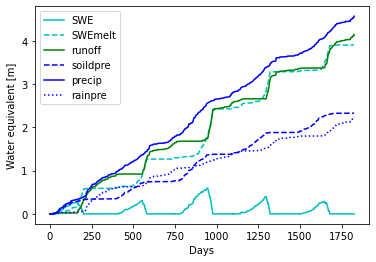

In [70]:
#DAVE
## Plot SnowModel outputs
#nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
stn = 3 
SWE = get_mod_output_line(sweFile,stn)
mx_swe = np.max(SWE)
print(mx_swe)
swe_days = sum(SWE>0)
print(swe_days)
ROFF = get_mod_output_line(roffFile,stn)
SMLT = get_mod_output_line(smltFile,stn)
SPRE = get_mod_output_line(spreFile,stn)
PREC = get_mod_output_line(precFile,stn)
RPRE = get_mod_output_line(rpreFile,stn)
TAIR = get_mod_output_line(tairFile,stn)
#SSUB = get_mod_output_line(ssubFile,stn)

# Plot the result
plt.plot(SWE,'c-', label = 'SWE' )   # add observation series
plt.plot(SMLT, 'c--', label = 'SWEmelt' )   # add observation series
plt.plot(ROFF, color='green', label = 'runoff')   # add observation series
plt.plot(SPRE,'b--', label = 'soildpre')   # add observation series
plt.plot(PREC,'b-', label = 'precip')   # add observation series
plt.plot(RPRE,'b:', label = 'rainpre')   # add observation series
#plt.plot(SSUB,'grey',linestyle=':', label = 'sublimat')   # add observation series
plt.legend()
plt.xlabel( "Days")
plt.ylabel( "Water equivalent [m]")
plt.show()

0.619348
983


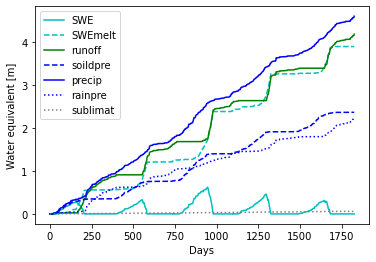

In [4]:
## Plot SnowModel outputs
#nx, ny, xll, yll, clsz, num_sim_days, st, ed = runSnowModel();
stn = 3 
SWE = get_mod_output(sweFile,stn)
mx_swe = np.max(SWE)
print(mx_swe)
swe_days = sum(SWE>0)
print(swe_days)
ROFF = get_mod_output(roffFile,stn)
SMLT = get_mod_output(smltFile,stn)
SPRE = get_mod_output(spreFile,stn)
PREC = get_mod_output(precFile,stn)
RPRE = get_mod_output(rpreFile,stn)
TAIR = get_mod_output(tairFile,stn)
SSUB = get_mod_output(ssubFile,stn)

# Plot the result
plt.plot(SWE,'c-', label = 'SWE' )   # add observation series
plt.plot(SMLT, 'c--', label = 'SWEmelt' )   # add observation series
plt.plot(ROFF, color='green', label = 'runoff')   # add observation series
plt.plot(SPRE,'b--', label = 'soildpre')   # add observation series
plt.plot(PREC,'b-', label = 'precip')   # add observation series
plt.plot(RPRE,'b:', label = 'rainpre')   # add observation series
plt.plot(SSUB,'grey',linestyle=':', label = 'sublimat')   # add observation series
plt.legend()
plt.xlabel( "Days")
plt.ylabel( "Water equivalent [m]")
plt.show()

## Plots hydro variables for each year

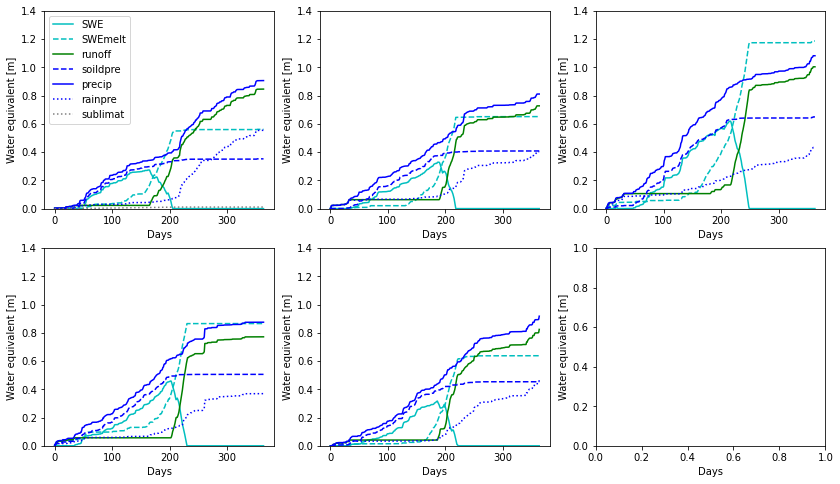

In [6]:
fig, axs = plt.subplots(2, 3,figsize=(14, 8))
#yr1
axs[0, 0].plot(SWE[0:364],'c-', label = 'SWE' )
axs[0, 0].plot(SMLT[0:364], 'c--', label = 'SWEmelt' )
axs[0, 0].plot(ROFF[0:364], color='green', label = 'runoff')
axs[0, 0].plot(SPRE[0:364],'b--', label = 'soildpre')
axs[0, 0].plot(PREC[0:364],'b-', label = 'precip')
axs[0, 0].plot(RPRE[0:364],'b:', label = 'rainpre')
axs[0, 0].plot(SSUB[0:364],'grey',linestyle=':', label = 'sublimat')   
axs[0, 0].set_ylim([0,1.4])
axs[0, 0].legend()

#yr2
axs[0, 1].plot(SWE[365:729],'c-', label = 'SWE' )
axs[0, 1].plot(SMLT[365:729]-SMLT[364], 'c--', label = 'SWEmelt' )
axs[0, 1].plot(ROFF[365:729]-ROFF[364], color='green', label = 'runoff')
axs[0, 1].plot(SPRE[365:729]-SPRE[364],'b--', label = 'soildpre')
axs[0, 1].plot(PREC[365:729]-PREC[364],'b-', label = 'precip')
axs[0, 1].plot(RPRE[365:729]-RPRE[364],'b:', label = 'rainpre')
axs[0, 1].set_ylim([0,1.4])

#yr3
axs[0, 2].plot(SWE[730:1094],'c-', label = 'SWE' )
axs[0, 2].plot(SMLT[730:1094]-SMLT[729], 'c--', label = 'SWEmelt' )
axs[0, 2].plot(ROFF[730:1094]-ROFF[729], color='green', label = 'runoff')
axs[0, 2].plot(SPRE[730:1094]-SPRE[729],'b--', label = 'soildpre')
axs[0, 2].plot(PREC[730:1094]-PREC[729],'b-', label = 'precip')
axs[0, 2].plot(RPRE[730:1094]-RPRE[729],'b:', label = 'rainpre')
axs[0, 2].set_ylim([0,1.4])

#yr4
axs[1, 0].plot(SWE[1095:1459],'c-', label = 'SWE' )
axs[1, 0].plot(SMLT[1095:1459]-SMLT[1094], 'c--', label = 'SWEmelt' )
axs[1, 0].plot(ROFF[1095:1459]-ROFF[1094], color='green', label = 'runoff')
axs[1, 0].plot(SPRE[1095:1459]-SPRE[1094],'b--', label = 'soildpre')
axs[1, 0].plot(PREC[1095:1459]-PREC[1094],'b-', label = 'precip')
axs[1, 0].plot(RPRE[1095:1459]-RPRE[1094],'b:', label = 'rainpre')
axs[1, 0].set_ylim([0,1.4])

#yr5
axs[1, 1].plot(SWE[1460:1824],'c-', label = 'SWE' )
axs[1, 1].plot(SMLT[1460:1824]-SMLT[1459], 'c--', label = 'SWEmelt' )
axs[1, 1].plot(ROFF[1460:1824]-ROFF[1459], color='green', label = 'runoff')
axs[1, 1].plot(SPRE[1460:1824]-SPRE[1459],'b--', label = 'soildpre')
axs[1, 1].plot(PREC[1460:1824]-PREC[1459],'b-', label = 'precip')
axs[1, 1].plot(RPRE[1460:1824]-RPRE[1459],'b:', label = 'rainpre')
axs[1, 1].set_ylim([0,1.4])


for ax in axs.flat:
    ax.set(xlabel='Days', ylabel='Water equivalent [m]')

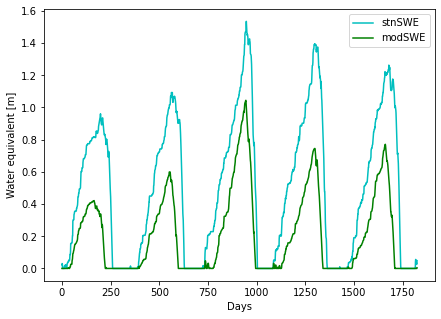

In [72]:
#DAVE
def calc_metrics1(stn):
    modSWE = get_mod_output_line(sweFile,stn)
    loc = gdf['code'][stn]
    stnSWE = df[loc].values
    return modSWE,stnSWE

modSWE,stnSWE = calc_metrics1(8)
# Plot the result
fig = plt.figure(figsize=(7, 5))
plt.plot(stnSWE,'c-', label = 'stnSWE' )  
plt.plot(modSWE,'g-', label = 'modSWE' ) 
plt.legend()
plt.xlabel( "Days")
plt.ylabel( "Water equivalent [m]")
plt.show()

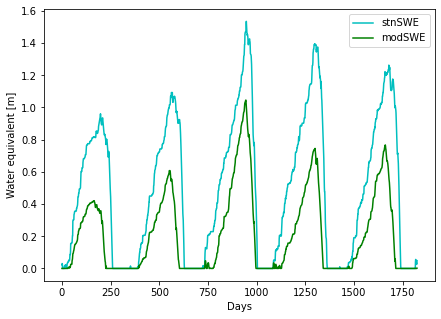

In [23]:
def calc_metrics1(stn):
    modSWE = get_mod_output(sweFile,stn)
    loc = gdf['code'][stn]
    stnSWE = df[loc].values
    return modSWE,stnSWE

modSWE,stnSWE = calc_metrics1(8)
# Plot the result
fig = plt.figure(figsize=(7, 5))
plt.plot(stnSWE,'c-', label = 'stnSWE' )  
plt.plot(modSWE,'g-', label = 'modSWE' ) 
plt.legend()
plt.xlabel( "Days")
plt.ylabel( "Water equivalent [m]")
plt.show()

# Function to make heatmap

In [73]:
#https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, vmin=-1, vmax=1, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


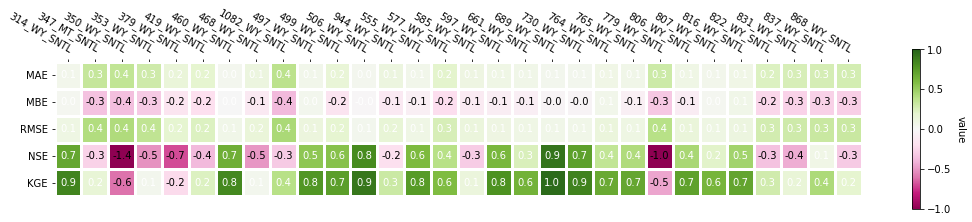

In [74]:
#DAVE
Metrics = ['MAE','MBE','RMSE','NSE','KGE']
Stations = gdf['code'].values


fig, ax = plt.subplots(figsize=(15, 3))
im, cbar = heatmap(swe_stats, Metrics, Stations, ax=ax,
                   cmap="PiYG", cbarlabel="value")
texts = annotate_heatmap(im,valfmt="{x:.1f}")
fig.tight_layout()
plt.show()


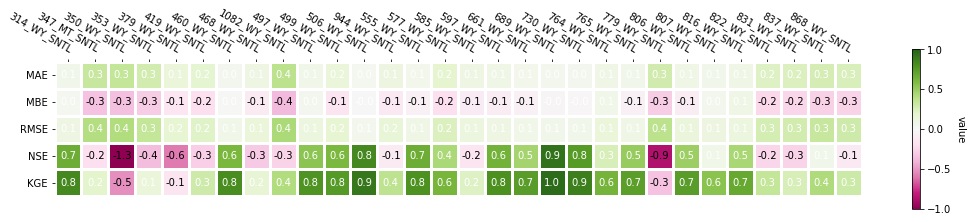

In [21]:
Metrics = ['MAE','MBE','RMSE','NSE','KGE']
Stations = gdf['code'].values


fig, ax = plt.subplots(figsize=(15, 3))
im, cbar = heatmap(swe_stats, Metrics, Stations, ax=ax,
                   cmap="PiYG", cbarlabel="value")
texts = annotate_heatmap(im,valfmt="{x:.1f}")
fig.tight_layout()
plt.show()

#fig.savefig("sample.png", dpi=300)